In [73]:
#####################################
# E-commerce User Behavior Analysis #
#####################################

# Required Libraries 
import pandas as pd # Data Analysis
import numpy as np # Numerical & Statistics
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Adv DataVisualization
from sklearn.cluster import KMeans # For user segmentation
from sklearn.preprocessing import StandardScaler # For scaling RFM values
from sklearn.metrics import silhouette_score # To evaluate clustering
from colorama import Fore, Style # Colors, For good data visualization
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
os.environ["OMP_NUM_THREADS"] = "3"

In [74]:
#################################### PHASE 1  ##########################################
  # Data Cleaning

In [75]:
# Preparing the dataset 
  # datatype
dtypes = {
    'user_id': 'int32',
    'item_id': 'int32',
    'behavior_types': 'category',
    'item_category': 'int32',
    'timestamp': 'int32'
      
  }


# Loading Dataset
user_behavior = pd.read_csv(
    r"C:\X-Files\Coding_File\Python\Final_Project.py\UserBehavior.csv", 
    encoding = "latin1",
    names = ["user_id", "item_id", "item_category", "behavior_type", "timestamp"],
    header = None,
    dtype = dtypes,
    nrows = 100000 # specifying limit rows due to much number of rows # Approx: 100-Million rows
    )

# Previewing the dataset
print(Fore.GREEN+"Displaying 100,000 Rows From the Dataset Below:"+Style.RESET_ALL)
print(user_behavior.head(100000))
print("\n")
print(Fore.GREEN+"Displaying Summary of the Dataset Below:"+Style.RESET_ALL)
print(user_behavior.info())
print("\n")
print(Fore.GREEN+"Quick Overview of Numerical Data of the Dataset Below:"+Style.RESET_ALL)
print(user_behavior.describe())

Displaying 100,000 Rows From the Dataset Below:
       user_id  item_id  item_category behavior_type   timestamp
0            1  2268318        2520377            pv  1511544070
1            1  2333346        2520771            pv  1511561733
2            1  2576651         149192            pv  1511572885
3            1  3830808        4181361            pv  1511593493
4            1  4365585        2520377            pv  1511596146
...        ...      ...            ...           ...         ...
99995  1004381  3214650        4391936            pv  1511884248
99996  1004381  4637603        3392099            pv  1511884729
99997  1004381  3833739        3392099            pv  1511884775
99998  1004381    33879         869231            pv  1511885059
99999  1004381  3504989         869231            pv  1511885089

[100000 rows x 5 columns]


Displaying Summary of the Dataset Below:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 col

In [76]:
# Checking for missing values
print(Fore.GREEN+"Boolean for NAN and Missing Values Below:"+Style.RESET_ALL)
print(user_behavior.isnull().sum())
# Drop missing values if any
user_behavior.dropna(inplace = True)

Boolean for NAN and Missing Values Below:
user_id          0
item_id          0
item_category    0
behavior_type    0
timestamp        0
dtype: int64


In [77]:
# Remove duplicate rows (if any)
initial_rows = user_behavior.shape[0]
user_behavior.drop_duplicates(inplace=True)
print(Fore.GREEN+f"Removed {initial_rows - user_behavior.shape[0]} duplicate rows."+Style.RESET_ALL)

Removed 0 duplicate rows.


In [78]:
# Converting timestamp into Datetime
user_behavior['timestamp'] = pd.to_datetime(user_behavior['timestamp'], unit = 's')
# Ensure timestamps are not in the future
user_behavior = user_behavior[user_behavior['timestamp'] <= pd.Timestamp.now()]

# verifying conversion
user_behavior['timestamp'].dtype

# Displaying
user_behavior.head(1000)

,user_id,item_id,item_category,behavior_type,timestamp
0,1,2268318,2520377,pv,2017-11-24 17:21:10
1,1,2333346,2520771,pv,2017-11-24 22:15:33
2,1,2576651,149192,pv,2017-11-25 01:21:25
3,1,3830808,4181361,pv,2017-11-25 07:04:53
4,1,4365585,2520377,pv,2017-11-25 07:49:06
...,...,...,...,...,...
995,1000040,1630357,1575622,pv,2017-11-27 16:01:14
996,1000040,13215,1575622,pv,2017-11-27 16:02:40
997,1000040,2031423,1575622,pv,2017-11-27 16:03:17
998,1000040,1514222,1575622,pv,2017-11-27 16:03:35


In [79]:
# Filter for only 'Buy' behavior
user_behavior_buy = user_behavior[user_behavior['behavior_type'] == 'buy']
print(user_behavior_buy.head(1000))

       user_id  item_id  item_category behavior_type           timestamp
71         100  1603476        2951233           buy 2017-11-25 03:18:28
73         100  2971043        4869428           buy 2017-11-25 13:45:49
100        100   598929        2429887           buy 2017-11-27 05:10:58
119        100  1046201        3002561           buy 2017-11-27 07:21:38
125        100  1606258        4098232           buy 2017-11-27 13:39:00
...        ...      ...            ...           ...                 ...
47321  1002034  1425149        5140516           buy 2017-11-25 14:10:32
47322  1002034  3153601        2354818           buy 2017-11-25 14:10:32
47340  1002034  4932147        3679635           buy 2017-11-26 04:45:32
47342  1002034  1958894        1973012           buy 2017-11-27 01:27:16
47357  1002034  4898965        3160926           buy 2017-12-02 13:12:39

[1000 rows x 5 columns]


In [80]:
# Count rows (buy)
print(f"Total 'Buy' Actions: {len(user_behavior_buy)}")

Total 'Buy' Actions: 2101


In [81]:
################################### PHASE 2   ###################################
  # Building RFM Model

In [82]:
# grouping only 'buy'  records by user_id
rfm_data = user_behavior_buy.groupby("user_id").agg({"timestamp": ['max', 'count']}).reset_index()
#rename columns for clarity
rfm_data.columns = ['user_id', 'last_purchase_date', 'frequency']

Preview of RFM Model


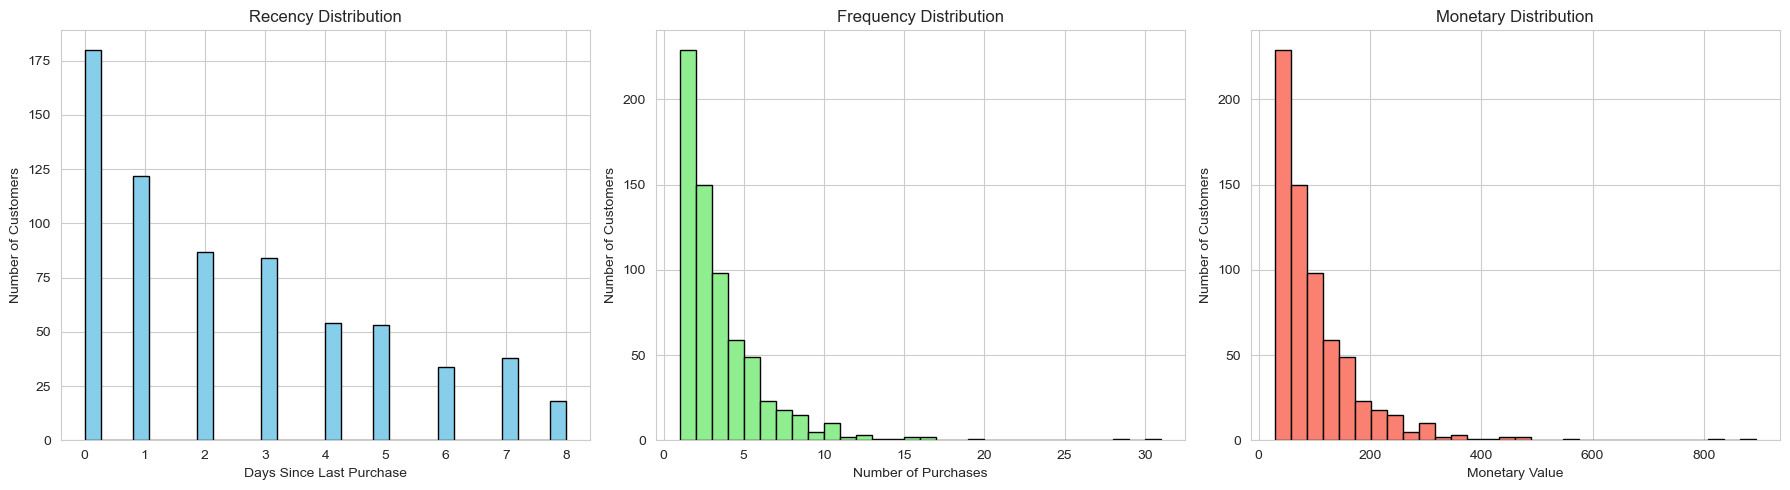

In [83]:
# Defining the reference date as the most recent purchase data in the dataset
reference_date = user_behavior_buy['timestamp'].max()

# calculating recency as the number of days between reference date and last purchase date
rfm_data['recency'] = (reference_date - rfm_data['last_purchase_date']).dt.days
# Remove users with extremely high frequency (e.g., top 0.1% percentile)
# Remove outliers
threshold = rfm_data['frequency'].quantile(0.999)
rfm_data = rfm_data[rfm_data['frequency'] <= threshold]
# Check for and remove rows with negative recency
rfm_data = rfm_data[rfm_data['recency'] >= 0]
# Estimating monetary value
average_order_value = 98
average_items_per_order = 3.4
average_item_price = average_order_value / average_items_per_order
rfm_data['monetary'] = rfm_data['frequency'] * average_item_price


print(Fore.GREEN+"Preview of RFM Model"+Style.RESET_ALL)
#rfm_data.head(10)

# Plot historgram for visualization

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency Histogram
axes[0].hist(rfm_data['recency'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Number of Customers')

# Frequency Histogram
axes[1].hist(rfm_data['frequency'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Number of Customers')

# Monetary Histogram
axes[2].hist(rfm_data['monetary'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Monetary Value')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [84]:
# Numerical statistics of the RFM Model
rfm_data.describe()

,user_id,last_purchase_date,frequency,recency,monetary
count,6.700000e+02,670,670.000000,670.000000,670.000000
mean,9.067801e+05,2017-11-30 20:58:46.471641856,3.071642,2.452239,88.535558
min,1.000000e+02,2017-11-24 17:19:06,1.000000,0.000000,28.823529
25%,1.000795e+06,2017-11-29 07:38:42.249999872,1.000000,0.000000,28.823529
50%,1.001950e+06,2017-12-01 10:57:09.500000,2.000000,2.000000,57.647059
75%,1.003229e+06,2017-12-03 00:35:31.500000,4.000000,4.000000,115.294118
max,1.004378e+06,2017-12-03 15:54:47,31.000000,8.000000,893.529412
std,2.798877e+05,NaN,2.929302,2.327445,84.432816


Preview Of Normalized RFM Data:


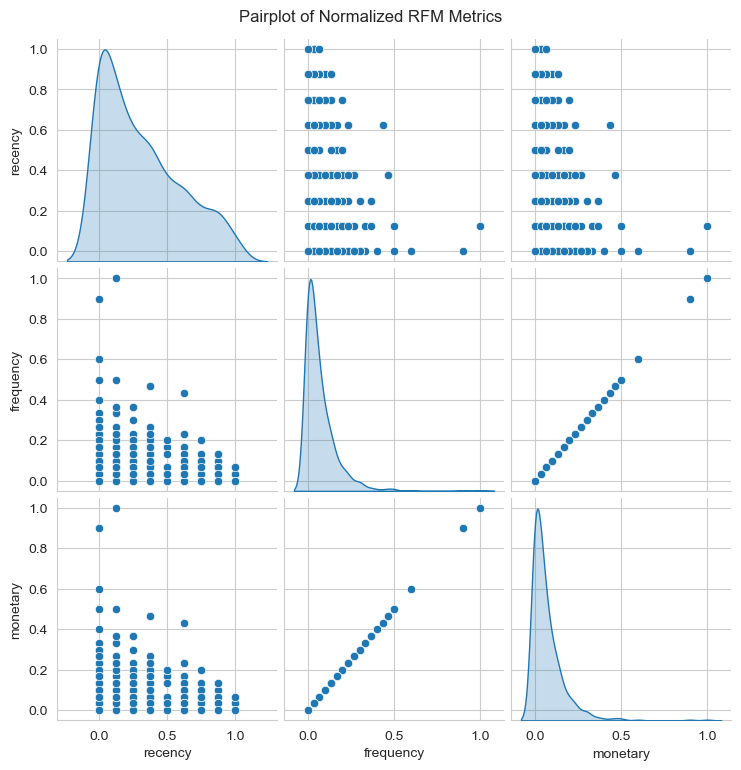

In [85]:
# Normalize RFM Values
  # Creating a copy of normalize
rfm_normalized = rfm_data[["recency", "frequency", "monetary"]].copy()
# Applying Min-Max Normalization
rfm_normalized = (rfm_normalized - rfm_normalized.min()) / (rfm_normalized.max() - rfm_normalized.min())
# Preview
print(Fore.GREEN+"Preview Of Normalized RFM Data:"+Style.RESET_ALL)
# plotting Pairplot for visualization
sns.pairplot(rfm_normalized, diag_kind='kde')

plt.suptitle('Pairplot of Normalized RFM Metrics', y=1.02)
plt.show()

In [86]:
################################### PHASE 3   ###################################
 # KMeans Clustering

# Let begins with, K = 4

Silhouette Scores for k=2 to 9:
k = 2, silhouette score = 0.5448
k = 3, silhouette score = 0.4067
k = 4, silhouette score = 0.3888
k = 5, silhouette score = 0.4537
k = 6, silhouette score = 0.4317
k = 7, silhouette score = 0.4497
k = 8, silhouette score = 0.4712
k = 9, silhouette score = 0.4854

Inertia: 15.101830058454338

RFM Data with cluster labels: 


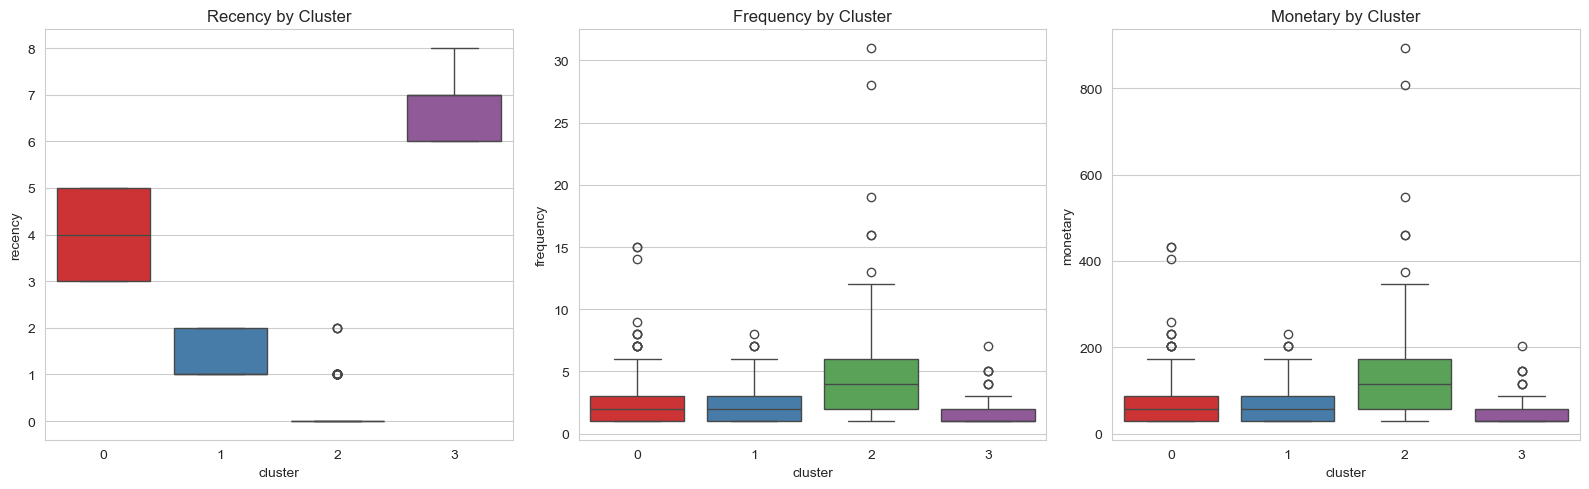

In [87]:
# Evaluate optimal number of clusters using silhouette score
print(Fore.GREEN + "Silhouette Scores for k=2 to 9:" + Style.RESET_ALL)
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_normalized)
    score = silhouette_score(rfm_normalized, labels)
    print(f"k = {k}, silhouette score = {score:.4f}")


print("\nInertia:", kmeans.inertia_)


# initialize and fit KMeans with 4 clusters
kmeans = KMeans(n_clusters = 4, random_state = 42)
rfm_normalized['cluster'] = kmeans.fit_predict(rfm_normalized)

# Add cluster info back to original RFM data
rfm_data['cluster'] = rfm_normalized['cluster']

# Preview with cluster
print(Fore.GREEN+"\nRFM Data with cluster labels: "+Style.RESET_ALL)
#rfm_data.head(10)

plt.figure(figsize=(16, 5))

for i, metric in enumerate(['recency', 'frequency', 'monetary']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='cluster', y=metric, data=rfm_data, hue='cluster', palette='Set1', legend=False)
    plt.title(f'{metric.capitalize()} by Cluster')

plt.tight_layout()
plt.show()

Cluster Summary:


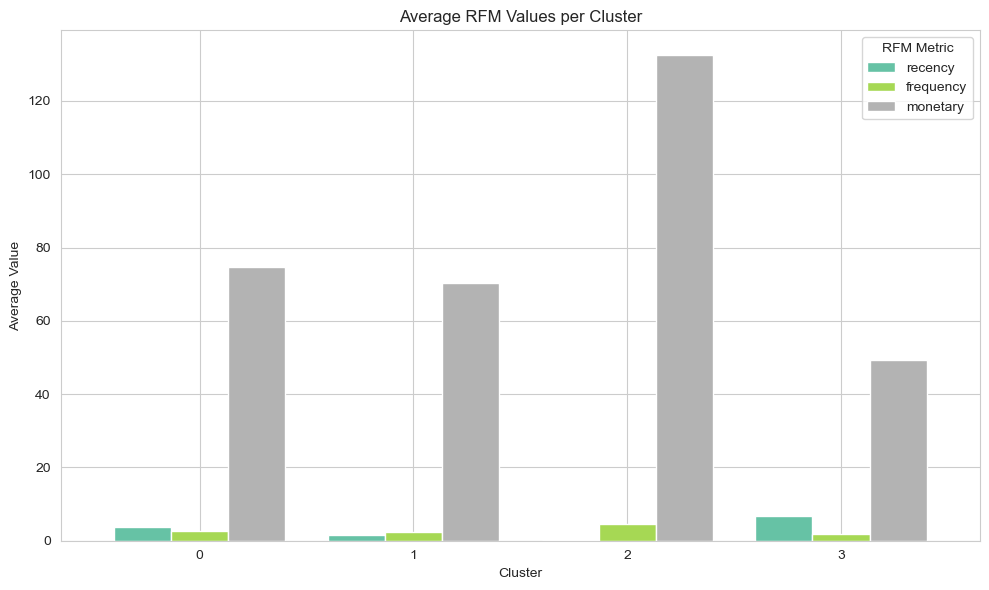

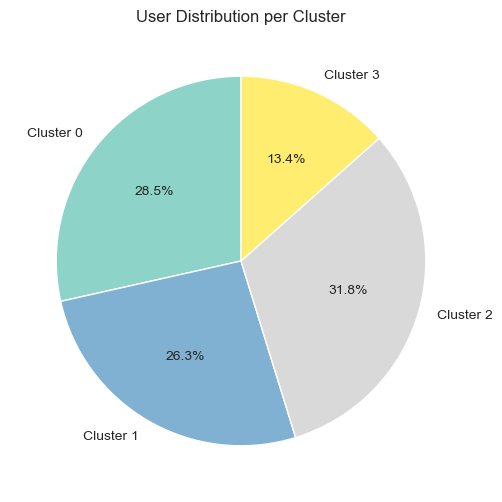

In [88]:
# Group by cluster to get average RFM values per segment
cluster_summary = rfm_data.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'user_id': 'count'
   }).rename(columns = {'user_id': 'num_user'})

# Preview 
print(Fore.GREEN+"Cluster Summary:"+Style.RESET_ALL)

# Reset index for plotting
cluster_summary_plot = cluster_summary.reset_index()

# Plot
cluster_summary_plot[['recency', 'frequency', 'monetary']].plot(
    kind='bar',
    figsize=(10, 6),
    width=0.8,
    colormap='Set2'
)

plt.xticks(ticks=range(len(cluster_summary_plot)), labels=cluster_summary_plot['cluster'], rotation=0)
plt.title("Average RFM Values per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.legend(title="RFM Metric")
plt.tight_layout()
plt.show()


 # Pie chart representation of Num_User per cluster
cluster_summary['num_user'].plot.pie(
    autopct='%1.1f%%',
    figsize=(6, 6),
    startangle=90,
    colormap='Set3',
    labels=[f"Cluster {i}" for i in cluster_summary.index]
)
plt.title("User Distribution per Cluster")
plt.ylabel('')
plt.show()

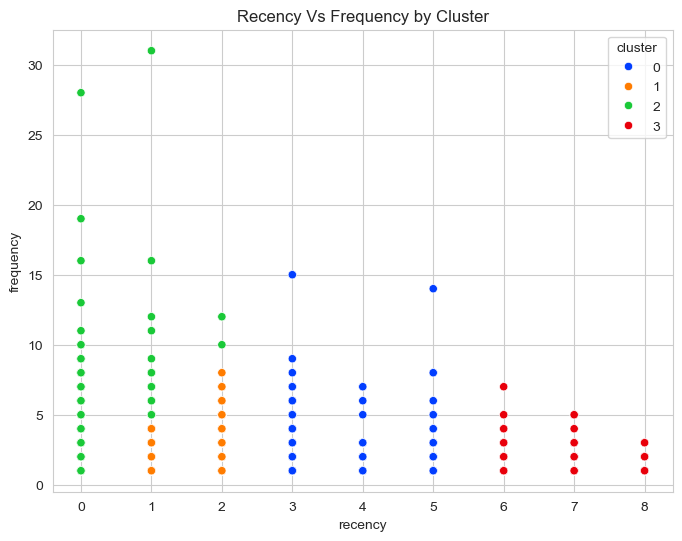

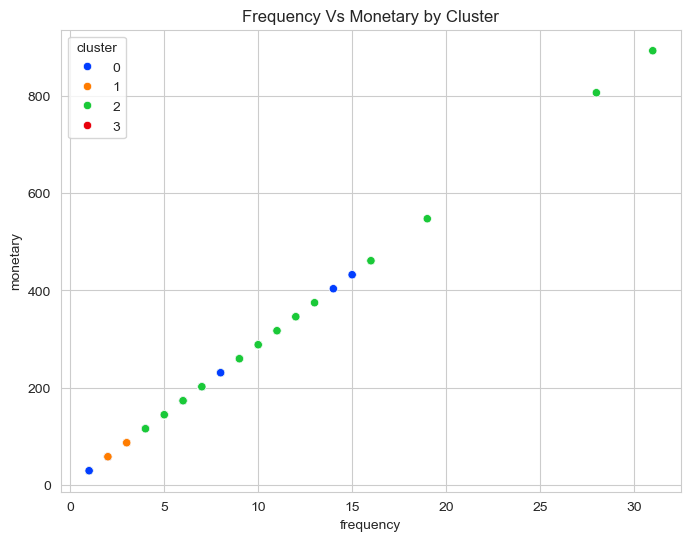

In [89]:
# 2D visualization of the cluster
# color 
palette = sns.color_palette("bright", len(rfm_data['cluster'].unique()))

# Recency VS Frequency
plt.figure(figsize = (8, 6))
sns.scatterplot(data = rfm_data, x = 'recency', y = 'frequency', hue = 'cluster', palette = palette)
plt.title("Recency Vs Frequency by Cluster")
plt.show()

# Frequency VS Monetary
plt.figure(figsize = (8, 6))
sns.scatterplot(data = rfm_data, x = 'frequency', y = 'monetary', hue = 'cluster', palette = palette)
plt.title("Frequency Vs Monetary by Cluster")
plt.show()

In [90]:
################################### FINAL PHASE   ###################################

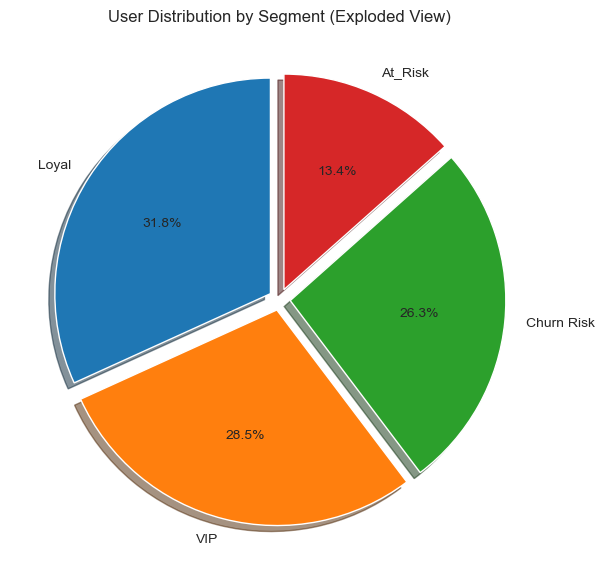

In [91]:
# Adding Labels to cluster
cluster_labels = {
    0: 'VIP',
    1: 'Churn Risk',
    2: 'Loyal',
    3: 'At_Risk'
}
rfm_data['segment'] = rfm_data['cluster'].map(cluster_labels)
 #Pie chart plot 
# Count users per segment
segment_counts = rfm_data['segment'].value_counts()

# Explode each slice slightly (adjust values if needed)
explode = [0.05] * len(segment_counts)

# Plot
plt.figure(figsize=(7, 7))
plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    shadow=True
)
plt.title("User Distribution by Segment (Exploded View)")
plt.ylabel("")
plt.show()

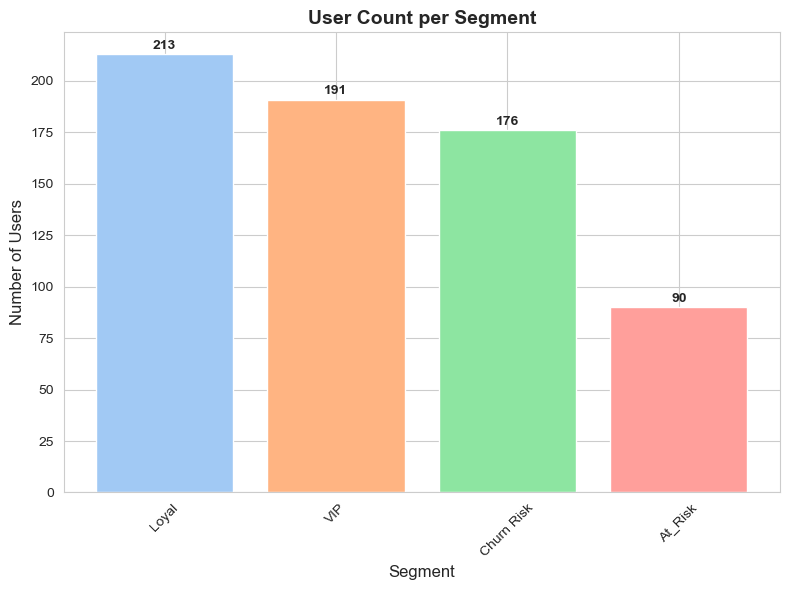

In [92]:
# Reviewing cluster segment
segment_counts = rfm_data['segment'].value_counts()

# Set seaborn style for aesthetics
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(segment_counts.index, segment_counts.values, color=sns.color_palette("pastel"))

# Add value annotations on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title('User Count per Segment', fontsize=14, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

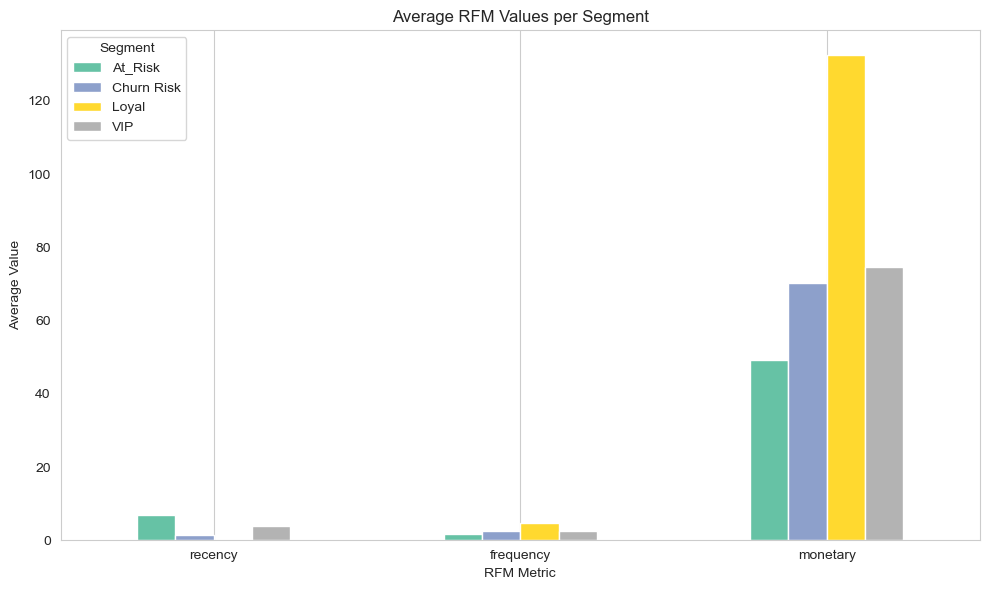

In [93]:
# Checking Average RFM values per segment
segment_summary = rfm_data.groupby('segment')[['recency', 'frequency', 'monetary']].mean()

# Transpose for plotting
segment_summary.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')

plt.title('Average RFM Values per Segment')
plt.xlabel('RFM Metric')
plt.ylabel('Average Value')
plt.legend(title='Segment')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [94]:
# Propose precision marketing strategies
# Define full strategy plan as a dictionary

# Define segment info
segment_info = {
    "VIP": [
        "High frequency, high monetary, recent buyers",
        "Offer exclusive access, early product launches, personalized services"
    ],
    "Loyal": [
        "Repeat customers, moderate spenders",
        "Upsell/Cross-sell with relevant recommendations, loyalty rewards"
    ],
    "Churn Risk": [
        "Previously active, now disengaged",
        "Win-back email campaigns, special reactivation discounts"
    ],
    "At_Risk": [
        "Infrequent, low spenders",
        "Retargeting ads, time-limited discounts to prompt action"
    ]
}

# Create DataFrame
segment_df = pd.DataFrame.from_dict(segment_info, orient='index', columns=['Description', 'Strategy'])

# Title HTML with styling
title_html = """
<h2 style='color:#2E86C1; text-align:center; font-family:Arial, sans-serif; margin-bottom: 15px;'>
    Precision Marketing Strategy
</h2>
"""

# Style the DataFrame
styled_df = segment_df.style.set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#2E86C1'),
        ('color', 'white'),
        ('text-align', 'center'),
        ('padding', '12px'),
        ('font-family', 'Arial, sans-serif')
    ]},
    {'selector': 'td', 'props': [
        ('padding', '12px'),
        ('text-align', 'left'),
        ('vertical-align', 'top'),
        ('font-family', 'Arial, sans-serif'),
        ('border', '1px solid #ddd')
    ]},
    {'selector': 'tr:nth-child(even)', 'props': [
        ('background-color', '#f9f9f9')
    ]}
]).set_properties(**{'border-collapse': 'collapse'})

# Display title and styled table
display(HTML(title_html))
display(styled_df)

,Description,Strategy
VIP,"High frequency, high monetary, recent buyers","Offer exclusive access, early product launches, personalized services"
Loyal,"Repeat customers, moderate spenders","Upsell/Cross-sell with relevant recommendations, loyalty rewards"
Churn Risk,"Previously active, now disengaged","Win-back email campaigns, special reactivation discounts"
At_Risk,"Infrequent, low spenders","Retargeting ads, time-limited discounts to prompt action"


Total users: 670
Data covers: 2017-11-24 to 2017-12-03

Segment Summary:
            recency  frequency  monetary
segment                                 
At_Risk        6.82       1.71     49.32
Churn Risk     1.48       2.44     70.26
Loyal          0.17       4.60    132.62
VIP            3.84       2.59     74.70


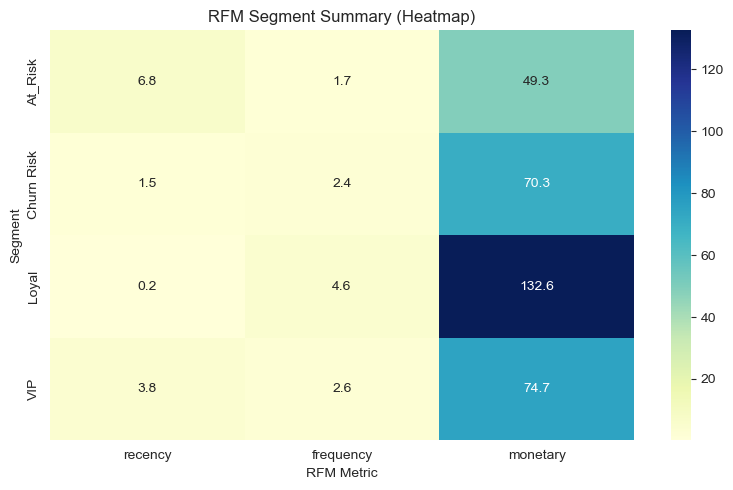

In [95]:
# Total number of users
total_users = rfm_data.shape[0]

# Date range of data
date_range = f"{rfm_data['last_purchase_date'].min().date()} to {rfm_data['last_purchase_date'].max().date()}"

# Group by segment and get average recency, frequency, monetary (rounded)
segment_summary = rfm_data.groupby('segment')[['recency', 'frequency', 'monetary']].mean().round(2)

print(Fore.GREEN+f"Total users: {total_users}"+Style.RESET_ALL)
print(Fore.GREEN+f"Data covers: {date_range}"+Style.RESET_ALL)
print(Fore.GREEN+"\nSegment Summary:"+Style.RESET_ALL)
print(segment_summary)

# Optional: Access individual segments for more detailed marketing notes
vip_recency = segment_summary.loc['VIP', 'recency']
vip_frequency = segment_summary.loc['VIP', 'frequency']
vip_monetary = segment_summary.loc['VIP', 'monetary']

plt.figure(figsize=(8, 5))
sns.heatmap(segment_summary, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('RFM Segment Summary (Heatmap)')
plt.ylabel('Segment')
plt.xlabel('RFM Metric')
plt.tight_layout()
plt.show()

In [96]:
# Define segment information with descriptions and tailored strategies
segment_info = {
    "VIPs (Top 10%)": [
        "Recent and frequent buyers with high spending potential",
        "Exclusive access, early product launches, personalized campaigns"
    ],
    "Loyal Users": [
        "Regular purchasers with steady engagement",
        "Loyalty programs, upselling, and cross-selling relevant products"
    ],
    "Churn Risks": [
        "Former buyers who stopped engaging",
        "Win-back emails, special discounts for reactivation"
    ],
    "At-Risk Users": [
        "Infrequent, low-value buyers",
        "Cost-effective retargeting ads, time-limited discount offers"
    ]
}

# Create a DataFrame from the dictionary
segment_df = pd.DataFrame.from_dict(segment_info, orient='index', columns=['Description', 'Proposed Strategy'])

# Style the DataFrame for better interactivity and readability
styled_df = segment_df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('padding', '12px'), ('text-align', 'left'), ('vertical-align', 'top')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
]).set_properties(**{'border': '1px solid #ddd', 'border-collapse': 'collapse'})

display(styled_df)

,Description,Proposed Strategy
VIPs (Top 10%),Recent and frequent buyers with high spending potential,"Exclusive access, early product launches, personalized campaigns"
Loyal Users,Regular purchasers with steady engagement,"Loyalty programs, upselling, and cross-selling relevant products"
Churn Risks,Former buyers who stopped engaging,"Win-back emails, special discounts for reactivation"
At-Risk Users,"Infrequent, low-value buyers","Cost-effective retargeting ads, time-limited discount offers"
